In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy import stats

In [2]:
import sys
import importlib
# sys.path.append('../ndtest/')
# import ndtest
# importlib.reload(ndtest);
# sys.path.append('../2DKS/')
# import KS2D
# importlib.reload(KS2D);

In [3]:
# Set parameters
a,b,c = 0.1,1.5,2.0

In [4]:
# Load data
τ1τ2_direct_full_data = np.loadtxt("../data/%.6f_%.6f_%.6f_jointTruncexpon_direct.dat"%(a,b,c))

In [5]:
# Load data
τ1τ2_rejection_full_data = np.loadtxt("../data/%.6f_%.6f_%.6f_jointTruncexpon_rejection.dat"%(a,b,c))

In [6]:
# Get total number of samples in data
# num_samples_data = τ1τ2_rejection_full_data.shape[0]
num_samples_data = τ1τ2_direct_full_data.shape[0]
print("There are a total of %d samples in the full data set."%num_samples_data)

There are a total of 1000000 samples in the full data set.


In [7]:
# Set start index (i.e, how many samples will be thrownaway due to equilibration)
equil_percent = 0.2
start = int(num_samples_data*equil_percent)

print("The %d first samples will be thrown away for equilibration."%start)

The 200000 first samples will be thrown away for equilibration.


In [8]:
τ1_direct_full_data = τ1τ2_direct_full_data[start:,0]
τ2_direct_full_data = τ1τ2_direct_full_data[start:,1]

In [9]:
τ1_rejection_full_data = τ1τ2_rejection_full_data[start:,0]
τ2_rejection_full_data = τ1τ2_rejection_full_data[start:,1]

### $\tau_1$ & $\tau_2$ sampling

In [10]:
def P_marg(x1,a,b,c):
    Z = (1/c**2)*(np.exp(-c*(b-a))-a*c+b*c-1)
    return (1/(c*Z))*(1-np.exp(-c*(b-x1)))

In [11]:
x1 = np.linspace(a,b,1000)

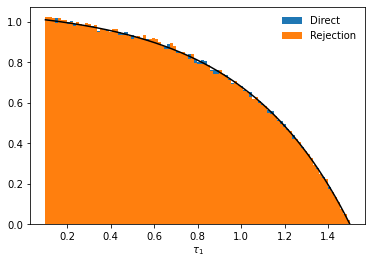

In [12]:
plt.hist(τ1_direct_full_data, density=True, bins=100,label="Direct");  # density=False would make counts
plt.hist(τ1_rejection_full_data, density=True, bins=100,label="Rejection");  # density=False would make counts
plt.plot(x1,P_marg(x1,a,b,c),color='black')
plt.xlabel(r'$\tau_1$');
plt.legend(frameon=False);

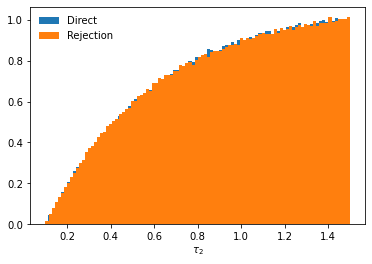

In [13]:
plt.hist(τ2_direct_full_data, density=True, bins=100,label='Direct');  # density=False would make counts
plt.hist(τ2_rejection_full_data, density=True, bins=100,label='Rejection');  # density=False would make counts
plt.xlabel(r'$\tau_2$');
plt.legend(frameon=False);

### $\tau_1 | \tau_2$ heatmap

In [14]:
num_bins = 30

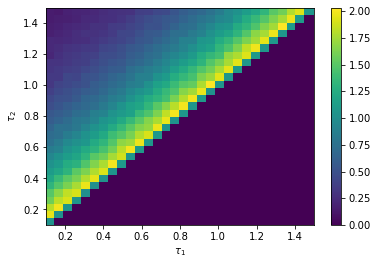

In [15]:
# fig,ax = plt.subplots(1,2,figsize=(10,4.5), dpi=100,sharey=True,tight_layout=True);
fig,ax = plt.subplots()
# plt.subplots_adjust(wspace=0.02);

h = ax.hist2d(τ1_direct_full_data,τ2_direct_full_data,density=True,bins=num_bins)
ax.set_xlabel(r"$\tau_1$")
ax.set_ylabel(r"$\tau_2$");
fig.colorbar(h[3], ax=ax)
# plt.savefig("../figures/joint_truncexpon_histogram_benchmark.pdf",dpi=300)

In [16]:
def _W(τ1,τ2,a,b,c):
    Z = (1/c**2)*(np.exp(-c*(b-a))-a*c+b*c-1)
    if (τ2<τ1): 
        return 0
    else:
        return np.exp(-c*(τ2-τ1))/Z

# Vectorize function so it's "numpy aware"
W = np.vectorize(_W)

### Compute exact 2D Distribution

In [17]:
_τ1,_τ2 = np.linspace(a,b,num_bins),np.linspace(a,b,num_bins)

# Create meshgrid
τ1,τ2 = np.meshgrid(_τ1,_τ2)

In [18]:
W = W(τ1,τ2,a,b,c);

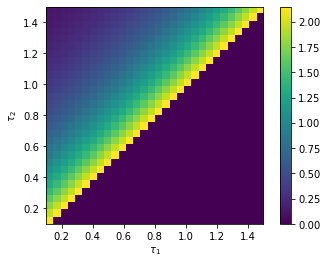

In [19]:
# Plot
plt.imshow(W,origin='lower',extent=[a,b,a,b]);
plt.xlabel(r'$\tau_1$')
plt.ylabel(r'$\tau_2$')
plt.colorbar();

### Compute relative errors

In [20]:
x_bins = np.linspace(a,b,num_bins+1)
y_bins = np.linspace(a,b,num_bins+1)
H = np.histogram2d(τ1_direct_full_data, τ2_direct_full_data, bins=(x_bins, y_bins),density=True) # H as in histogram
H = H[0].T # Why do we need to take transpose?
relErr = np.nan_to_num((W-H)/W,nan=0.0, posinf=0.0, neginf=0.0);
relErr_direct = np.ma.masked_array(relErr,mask=relErr==np.diag(relErr))

<ipython-input-20-d700dbbb5c80>:5: RuntimeWarning: invalid value encountered in true_divide
  relErr = np.nan_to_num((W-H)/W,nan=0.0, posinf=0.0, neginf=0.0);


In [21]:
x_bins = np.linspace(a,b,num_bins+1)
y_bins = np.linspace(a,b,num_bins+1)
H = np.histogram2d(τ1_rejection_full_data, τ2_rejection_full_data, bins=(x_bins, y_bins),density=True) # H as in histogram
H = H[0].T # Why do we need to take transpose?
relErr = np.nan_to_num((W-H)/W,nan=0.0, posinf=0.0, neginf=0.0);
relErr_rejection = np.ma.masked_array(relErr,mask=relErr==np.diag(relErr))

<ipython-input-21-6f34e8aeb171>:5: RuntimeWarning: invalid value encountered in true_divide
  relErr = np.nan_to_num((W-H)/W,nan=0.0, posinf=0.0, neginf=0.0);


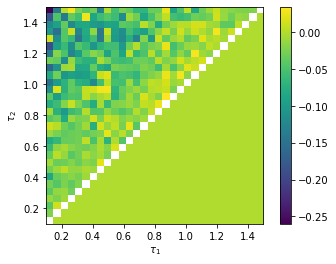

In [22]:
relErr = np.ma.masked_array(relErr,mask=relErr==np.diag(relErr))
plt.imshow((relErr),origin='lower',extent=[a,b,a,b]);
plt.xlabel(r'$\tau_1$')
plt.ylabel(r'$\tau_2$')
plt.colorbar();
# plt.title(r'$c<0$');
# plt.savefig("0.100000_1.300000_-0.500000_relativeError_masked_noAbs.pdf",dpi=400)

## Make combined plot

In [23]:
# Get maximum and minimum values from the exact joint distribution P(τ1,τ2)
vmax = np.max(W)
vmin = np.min(W)

In [24]:
rel_err_vmax_rejection = np.max(relErr_rejection)
rel_err_vmin_rejection = np.min(relErr_rejection)

In [25]:
rel_err_vmax_direct = np.max(relErr_direct)
rel_err_vmin_direct = np.min(relErr_direct)

In [26]:
vmax_rel_err = max(rel_err_vmax_rejection,rel_err_vmax_direct)
vmin_rel_err = min(rel_err_vmin_rejection,rel_err_vmin_direct)

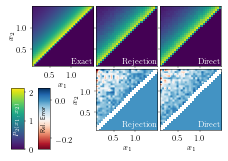

In [27]:
with plt.style.context('../IOP_large.mplstyle'):

    fig9 = plt.figure(constrained_layout=False, figsize=[1.1*3.083,1.8*1.905])
#    plt.subplots_adjust(left=0.2)
    
    widths = [1,1,1]
    heights = [1,1,1]
    gs2 = fig9.add_gridspec(ncols=3, nrows=3, width_ratios=widths,height_ratios=heights,
                            hspace=0.05,wspace=0.05)

    # gs2 = fig9.add_gridspec(nrows=2, ncols=3,hspace=0.08,wspace=0.05)
    
    f9_ax1 = fig9.add_subplot(gs2[0,0])

    f9_ax2 = fig9.add_subplot(gs2[0,1],sharey=f9_ax1,sharex=f9_ax1)
    f9_ax3 = fig9.add_subplot(gs2[0,2],sharey=f9_ax1,sharex=f9_ax1)

    f9_ax4 = fig9.add_subplot(gs2[1,1],sharey=f9_ax1,sharex=f9_ax1)
    f9_ax5 = fig9.add_subplot(gs2[1,2],sharey=f9_ax1,sharex=f9_ax1)

    # Exact
    im = f9_ax1.imshow(W,origin='lower',extent=[a,b,a,b], aspect="auto",vmax=vmax,vmin=vmin, rasterized=True)
    f9_ax1.set_xlabel(r"$x_1$")
    f9_ax1.set_ylabel(r"$x_2$");
    f9_ax1.annotate(r"$\rm{Exact}$",(0.99,0.05),xycoords="axes fraction",color="white", ha='right')

    # Rejection
    h_rejection =f9_ax2.hist2d(τ1_rejection_full_data,τ2_rejection_full_data,density=True,bins=num_bins,vmax=vmax,vmin=vmin,rasterized=True)
    # f9_ax2.set_ylabel(r"$x_2$");
    f9_ax2.annotate(r"$\rm{Rejection}$",(0.99,0.05),xycoords="axes fraction",color="white", ha='right')
    f9_ax2.tick_params(labelbottom=False)    
    f9_ax2.tick_params(labelleft=False)    

    # Exact/Rejection Relative Error
    im2 = f9_ax4.imshow(relErr_rejection,origin='lower',extent=[a,b,a,b], aspect="auto",cmap="RdBu",vmax=vmax_rel_err,vmin=vmin_rel_err,rasterized=True);
    f9_ax4.set_xlabel(r"$x_1$")
    f9_ax4.set_ylabel(r"$x_2$");
    f9_ax4.annotate(r"$\rm{Rejection}$",(0.99,0.05),xycoords="axes fraction",color="white", ha='right')
    # fig.colorbar(im2, ax=f9_ax4)
    # fig.colorbar(im2, ax=f9_ax4).remove()

    # Inversion
    h = f9_ax3.hist2d(τ1_direct_full_data,τ2_direct_full_data,density=True,bins=num_bins,vmax=vmax,vmin=vmin,rasterized=True)
    f9_ax3.annotate(r"$\rm{Direct}$",(0.99,0.05),xycoords="axes fraction",color="white", ha='right')
    f9_ax3.tick_params(labelbottom=False)    
    f9_ax3.tick_params(labelleft=False)    

    # Exact/Inversion Relative Error
    im2 = f9_ax5.imshow(relErr_direct,origin='lower',extent=[a,b,a,b], aspect="auto",cmap="RdBu",vmax=vmax_rel_err,vmin=vmin_rel_err,rasterized=True);
    f9_ax5.set_xlabel(r"$x_1$")
    f9_ax5.annotate(r"$\rm{Direct}$",(0.99,0.05),xycoords="axes fraction",color="white", ha='right')
    f9_ax5.tick_params(labelleft=False)    

#     # # add colorbars
#     cbaxes_1 = fig9.add_axes([0.92, 0.636, 0.03, 0.244]) 
#     cbaxes_2 = fig9.add_axes([0.92, 0.381, 0.03, 0.244]) 

#     # position for the colorbar
#     cb_1 = plt.colorbar(im, cax = cbaxes_1, label=r"$P_2(x_1,x_2)$")
#     cb_2 = plt.colorbar(im2, cax = cbaxes_2, label=r"$\rm{Relative\;Error}$")
    
    # add colorbars
    cbaxes_1 = fig9.add_axes([0.04, 0.3, 0.05, 0.25]) 
    cbaxes_2 = fig9.add_axes([0.15, 0.3, 0.05, 0.25]) 

    # position for the colorbar
    cb_1 = plt.colorbar(im, cax = cbaxes_1)
    cb_2 = plt.colorbar(im2, cax = cbaxes_2)
    
    cbaxes_1.annotate(r"$P_2(x_1,x_2)$",(0.25,0.5),xycoords="axes fraction",color="w", va='center', fontsize=6,rotation=90)
    cbaxes_2.annotate(r"Rel. Error",(0.25,0.5),xycoords="axes fraction",color="k", va='center', fontsize=6,rotation=90)


        
# cbar.ax.set_ylabel('# of contacts', rotation=270)

    fig9.savefig("../figures/joint_truncexpon_histogram_benchmark.pdf",dpi=300)
    fig9.savefig("../figures/joint_truncexpon_histogram_benchmark.svg",dpi=300)

